In [1]:
from escher import Builder
import os
from time import sleep

from labUtils.fba.fba_tools import load_model, load_fba_data

## Load the organism file.

In [2]:
model = load_model("H:/ROBOT_SCIENTIST/E_coli/iML1515.json")
model

Name,iML1515
Memory address,1a79fabba10
Number of metabolites,1877
Number of reactions,2712
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


# Load the experiment data

> If the data files are created by the pipeline, you must have 'df_flux.csv' and 'growth_rates.csv', created in different folders based on starin, averaging, etc.
>
> Check the parameters below to change the data source selection.

In [20]:
import pandas as pd

strain = "WT"
replication = "no_replicates"
gr_column= "mv_mu_max"
well_column = "well"

# replication = "replicates"
# gr_column= "mv_mu_max"
# well_column = "wells"

# experiment = "mediabotJLF2"

(df_data,
 fixed_columns, 
 medium_columns, 
 supplement_columns, 
 df_predictions) = load_fba_data(per_strain=True,
                                 replication = replication,
                                 strain=strain,
                                 #experiment=experiment,
                                 well_column=well_column,
                                 datasource_path="H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed"
                                )


all_medium_columns = fixed_columns + medium_columns + supplement_columns    

print("=" * 50)
print("Fixed exchanges:")
print(fixed_columns)
print("=" * 50)
print("Medium exchanges:")
print(medium_columns[:10])
print(medium_columns[10:])
print("=" * 50)
print("Supplement exchanges:")
print(supplement_columns[:8])
print(supplement_columns[8:16])
print(supplement_columns[16:])

Fixed exchanges:
['EX_h2o_e', 'EX_mobd_e', 'EX_ni2_e', 'EX_o2_e', 'EX_tungs_e']
Medium exchanges:
['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe3_e', 'EX_h_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_na1_e']
['EX_nh4_e', 'EX_pi_e', 'EX_so4_e', 'EX_zn2_e']
Supplement exchanges:
['EX_ade_e', 'EX_ala__L_e', 'EX_arg__L_e', 'EX_asn__L_e', 'EX_asp__L_e', 'EX_cys__L_e', 'EX_glc__D_e', 'EX_gln__L_e']
['EX_glu__L_e', 'EX_gly_e', 'EX_his__L_e', 'EX_ile__L_e', 'EX_leu__L_e', 'EX_lys__L_e', 'EX_met__L_e', 'EX_phe__L_e']
['EX_pro__L_e', 'EX_ser__L_e', 'EX_succ_e', 'EX_sucr_e', 'EX_thr__L_e', 'EX_trp__L_e', 'EX_tyr__L_e', 'EX_ura_e', 'EX_val__L_e']


# Solve FBA


> We using the "find_fba_solutions_scaling_factor" that adjust the uptakes bounds for best fit.

In [14]:
from labUtils.fba.fba_tools import find_fba_solutions_scaling_factor
df_data, df_fluxes, df_shadow_prices = find_fba_solutions_scaling_factor(df_data, 
                                                                         model,
                                                                         all_medium_columns,
                                                                         use_sfba=False,
                                                                         gr_column=gr_column,
                                                                        )

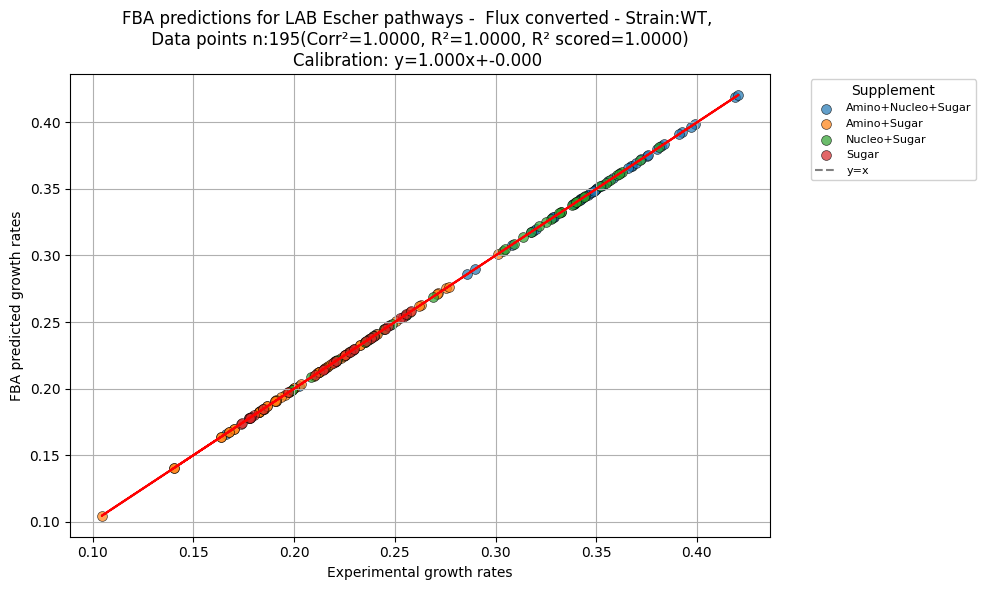

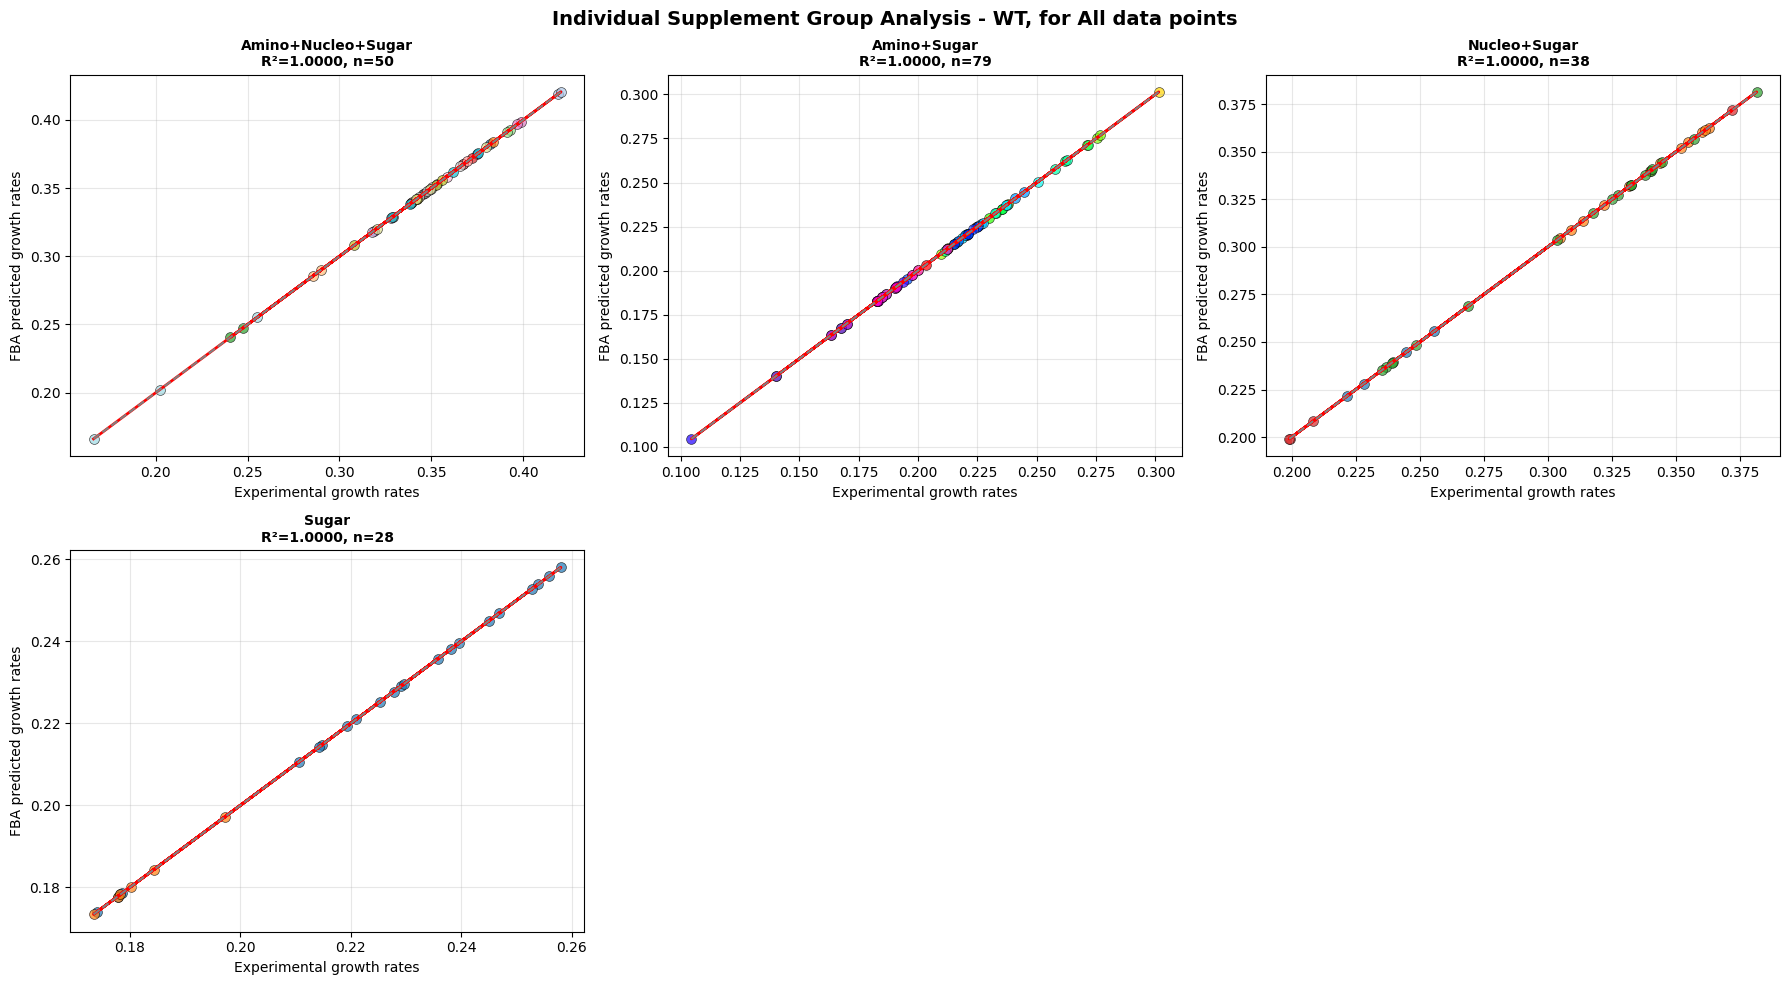

In [15]:
from labUtils.fba.visualisations import plot_fba_predictions

plot_fba_predictions(df_data, 
                     gr_column=gr_column,
                     per_strain=True,
                     replication = replication,
                     strain=strain,
                     #experiment=experiment,
                     title="FBA predictions for LAB Escher pathways - "
                     )

# IMPORTANT
## In the following, the 'solution_index' is a variable that selects the record in the 'combinded_data' dataframe will be plotted. You can check the 'combinded_data' dataframe, then, select the relevant index to study furthur.

In [16]:
solution_index = 1  # Change this index to visualize different solutions
assert df_data.iloc[solution_index]["fba_status"] == 'optimal', f"Solution at index {solution_index} is not optimal."
assert solution_index < len(df_fluxes), f"Solution index {solution_index} is out f bounds for fluxes list of length {len(df_fluxes)}."

row_experiment = df_data.iloc[solution_index]["experiment"]
row_well = df_data.iloc[solution_index][well_column]

# Plot the OD time series

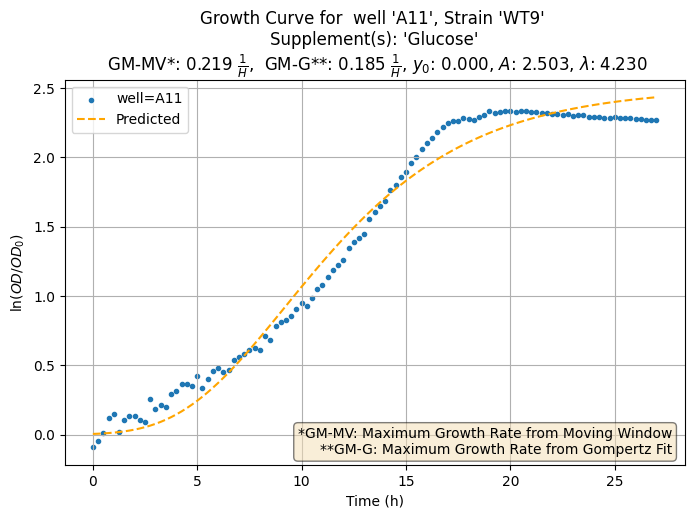

In [17]:
from labUtils.growth_rates import plot_single_series

series_data = df_predictions[(df_predictions["experiment"] == row_experiment) & (df_predictions[well_column] == row_well)].copy()

plot_single_series(series_data, 
                   group_keys=(row_well,),
                   value_col='log_od_od0',
                   group_cols=[well_column],
                   standard_deviation_column='od600_std',
                   save_plot = False
                   )

# Core metabolism

In [8]:
builder = Builder(    
    map_name='e_coli_core.Core metabolism',  
    model=model,
    reaction_data=df_fluxes.iloc[solution_index],
    metabolite_data=df_shadow_prices.iloc[solution_index]
)

# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = True
builder.hide_all_labels = False

# Set color scale
builder.reaction_scale_preset = 'GaBuRd'

# Make all the arrows three times as thick
# builder.reaction_scale = [
#     {k: v * 3 if k == 'size' else v for k, v in x.items()}
#     for x in builder.reaction_scale
# ]

builder

Builder(hide_all_labels=False, hide_secondary_metabolites=True, metabolite_data={'octapb_c': np.float64(0.0), …

# Nucleotide Metabolism

In [9]:
from labUtils.fba.visualisations import create_iml1515_map
# === Configuration ===
iml1515_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.json"
ijo1366_path = "H:/ROBOT_SCIENTIST/E_coli/iJO1366.xml"
output_map_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.Nucleotide_metabolism.json"

# === Create the map (only run once) ===
if not os.path.exists(output_map_path):
    create_iml1515_map(
        source_map_name='iJO1366.Nucleotide metabolism',
        iml1515_model_path=iml1515_path,
        ijo1366_model_path=ijo1366_path,
        output_path=output_map_path
    )
else:
    print(f"Map already exists at: {output_map_path}")
    print("Delete the file if you want to regenerate it.")


Map already exists at: H:/ROBOT_SCIENTIST/E_coli/iML1515.Nucleotide_metabolism.json
Delete the file if you want to regenerate it.


In [10]:
# Use the custom iML1515 Nucleotide Metabolism map

# Create the builder with your custom iML1515 map
builder = Builder(
    map_json='H:/ROBOT_SCIENTIST/E_coli/iML1515.Nucleotide_metabolism.json',  
    model=model,  #  iML1515 model 
    reaction_data=df_fluxes.iloc[solution_index],
    metabolite_data=df_shadow_prices.iloc[solution_index]
)

# Customize appearance
builder.hide_secondary_metabolites = True
builder.hide_all_labels = False
builder.reaction_scale_preset = 'GaBuRd'

# Display
builder

Builder(hide_all_labels=False, hide_secondary_metabolites=True, metabolite_data={'octapb_c': np.float64(0.0), …

# Fatty acid biosynthesis

In [11]:
# === Configuration ===
iml1515_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.json"
ijo1366_path = "H:/ROBOT_SCIENTIST/E_coli/iJO1366.xml"
output_map_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.Fatty_acid_biosynthesis_saturated.json"

# === Create the map (only run once) ===
if not os.path.exists(output_map_path):
    create_iml1515_map(
        source_map_name='iJO1366.Fatty acid biosynthesis (saturated)',
        iml1515_model_path=iml1515_path,
        ijo1366_model_path=ijo1366_path,
        output_path=output_map_path
    )
else:
    print(f"Map already exists at: {output_map_path}")
    print("Delete the file if you want to regenerate it.")

#

# Create the builder with your custom iML1515 map
builder = Builder(
    map_json='H:/ROBOT_SCIENTIST/E_coli/iML1515.Fatty_acid_biosynthesis_saturated.json',  
    model=model,  # iML1515 model 
    reaction_data=df_fluxes.iloc[solution_index],
    metabolite_data=df_shadow_prices.iloc[solution_index]
)

# Customize appearance
builder.hide_secondary_metabolites = True
builder.hide_all_labels = False
builder.reaction_scale_preset = 'GaBuRd'

# Display
builder

Map already exists at: H:/ROBOT_SCIENTIST/E_coli/iML1515.Fatty_acid_biosynthesis_saturated.json
Delete the file if you want to regenerate it.


Builder(hide_all_labels=False, hide_secondary_metabolites=True, metabolite_data={'octapb_c': np.float64(0.0), …

# Nucleotide and histidine biosynthesis

In [12]:
# === Configuration ===
iml1515_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.json"
ijo1366_path = "H:/ROBOT_SCIENTIST/E_coli/iJO1366.xml"
output_map_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.Nucleotide_and_histidine_biosynthesis.json"

# === Create the map (only run once) ===
if not os.path.exists(output_map_path):
    create_iml1515_map(
        source_map_name='iJO1366.Nucleotide and histidine biosynthesis',
        iml1515_model_path=iml1515_path,
        ijo1366_model_path=ijo1366_path,
        output_path=output_map_path
    )
else:
    print(f"Map already exists at: {output_map_path}")
    print("Delete the file if you want to regenerate it.")

#

# Create the builder with your custom iML1515 map
builder = Builder(
    map_json='H:/ROBOT_SCIENTIST/E_coli/iML1515.Nucleotide_and_histidine_biosynthesis.json', 
    model=model,  #  iML1515 model 
    reaction_data=df_fluxes.iloc[solution_index],
    metabolite_data=df_shadow_prices.iloc[solution_index]
)

# Customize appearance
builder.hide_secondary_metabolites = True
builder.hide_all_labels = False
builder.reaction_scale_preset = 'GaBuRd'

# Display
builder

Map already exists at: H:/ROBOT_SCIENTIST/E_coli/iML1515.Nucleotide_and_histidine_biosynthesis.json
Delete the file if you want to regenerate it.


Builder(hide_all_labels=False, hide_secondary_metabolites=True, metabolite_data={'octapb_c': np.float64(0.0), …

# Central metabolism

In [17]:
# === Configuration ===
iml1515_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.json"
ijo1366_path = "H:/ROBOT_SCIENTIST/E_coli/iJO1366.xml"
output_map_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.Central_metabolism.json"

# === Create the map (only run once) ===
if not os.path.exists(output_map_path):
    create_iml1515_map(
        source_map_name='iJO1366.Central metabolism',
        iml1515_model_path=iml1515_path,
        ijo1366_model_path=ijo1366_path,
        output_path=output_map_path
    )
else:
    print(f"Map already exists at: {output_map_path}")
    print("Delete the file if you want to regenerate it.")

#

# Create the builder with your custom iML1515 map
builder = Builder(
    map_json='H:/ROBOT_SCIENTIST/E_coli/iML1515.Central_metabolism.json', 
    model=model,  # iML1515 model
    reaction_data=df_fluxes.iloc[solution_index],
    metabolite_data=df_shadow_prices.iloc[solution_index]
)

# Customize appearance
builder.hide_secondary_metabolites = True
builder.hide_all_labels = False
builder.reaction_scale_preset = 'GaBuRd'

# Display
display(builder)

Map already exists at: H:/ROBOT_SCIENTIST/E_coli/iML1515.Central_metabolism.json
Delete the file if you want to regenerate it.


Builder(hide_all_labels=False, hide_secondary_metabolites=True, metabolite_data={'octapb_c': np.float64(0.0), …

# Fatty acid beta-oxidation

In [10]:
# === Configuration ===
iml1515_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.json"
ijo1366_path = "H:/ROBOT_SCIENTIST/E_coli/iJO1366.xml"
output_map_path = "H:/ROBOT_SCIENTIST/E_coli/iML1515.Fatty_acid_beta_oxidation.json"

# === Create the map (only run once) ===
if not os.path.exists(output_map_path):
    create_iml1515_map(
        source_map_name='iJO1366.Fatty acid beta-oxidation',
        iml1515_model_path=iml1515_path,
        ijo1366_model_path=ijo1366_path,
        output_path=output_map_path
    )
else:
    print(f"Map already exists at: {output_map_path}")
    print("Delete the file if you want to regenerate it.")

#

# Create the builder with your custom iML1515 map
builder = Builder(
    map_json='H:/ROBOT_SCIENTIST/E_coli/iML1515.Fatty_acid_beta_oxidation.json',  
    model=model,  #  iML1515 model
    reaction_data=df_fluxes.iloc[solution_index],
    metabolite_data=df_shadow_prices.iloc[solution_index]
)

# Customize appearance
builder.hide_secondary_metabolites = True
builder.hide_all_labels = False
builder.reaction_scale_preset = 'GaBuRd'

# Display
builder

Map already exists at: H:/ROBOT_SCIENTIST/E_coli/iML1515.Fatty_acid_beta_oxidation.json
Delete the file if you want to regenerate it.


Builder(hide_all_labels=False, hide_secondary_metabolites=True, metabolite_data={'octapb_c': np.float64(0.0), …